## Fairness/ALE Plots experiment notebook
An experiment to compute the effect of each feature in fairness using the ALE Plots method.



Datasets used: 
- `adult (Adult)` :<br>The UCI Adult dataset contains 14 features, which can be divided into two categories: demographic and income-related.<br> The demographic features include:

    age: continuous.<br>
    fnlwgt : continuous, represents final weight, which is the number of units in the target population that the responding unit represents.<br>
    workclass: categorical, with values 'Private', 'Local-gov', 'Self-emp-not-inc', 'Federal-gov', 'State-gov', 'Self-emp-inc', 'Without-pay'.<br>
    education: categorical, with values '11th', 'HS-grad', 'Assoc-acdm', 'Some-college', '10th', ..., '9th', 'Doctorate', '12th', '1st-4th', 'Preschool'.<br>
    education-num: continuous with values 1 to 16, one number assigned to each label of education feature.<br>
    marital-status: categorical, with values 'Never-married', 'Married-civ-spouse', 'Widowed', 'Separated', 'Divorced', 'Married-spouse-absent', 'Married-AF-spouse'.<br>
    occupation: categorical, with values such as 'Machine-op-inspct', 'Farming-fishing', 'Protective-serv'.<br>
    relationship: categorical, with values 'Own-child', 'Husband', 'Not-in-family', 'Unmarried', 'Wife', 'Other-relative'.<br>
    race: categorical, with values such as white, black, and Asian.<br>
    sex: categorical, with values male and female.<br>
    
    The income-related features include:<br>

    hours-per-week: continuous.<br>
    native-country: categorical, with values such as United-States, Mexico, and Germany.<br>
    capital-gain: continuous, represent the amount of money an individual has gained from the sale of investments such as stocks, bonds, or real estate.<br>
    capital-loss: continuous, represent the amount of money an individual has lost from the sale of investments such as stocks, bonds, or real estate..<br>
    The target feature is the income, which is binary:<br>
    income: categorical, with values less than or equal to 50K and greater than 50K.<br>

Reference Links: https://archive.ics.uci.edu/ml/datasets/adult

In [1]:
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(os.path.join(project_root, "src"))

import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from aif360.sklearn.metrics.metrics import disparate_impact_ratio,average_odds_difference,statistical_parity_difference,equal_opportunity_difference 
from matplotlib.pyplot import *
from omnixai.data.tabular import Tabular
from omnixai.preprocessing.tabular import TabularTransform
from omnixai.preprocessing.base import Identity
from omnixai.preprocessing.encode import Ordinal
import xgboost
import matplotlib.pyplot as plt
from collections import OrderedDict
import re
import warnings
from FALElib import *
from helpers import *
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
warnings.filterwarnings('ignore') 


pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'
pip install 'aif360[OptimalTransport]'


## Loading Dataset/ Preprocessing

- Binarize the sensitive attributes: 1 being set to be the privileged group and 0 as the unprivileged.
- Binarize the label column: 1 being the positive outcome and 0 else.


In [2]:
X,y,feature_names,categorical_columns,prot_attr = load_dataset('adult')
X , y = binarize(X,y)
X.head()

age  workclass  education-num      marital-status  \
race sex                                                       
0    1    25.0    Private            7.0       Never-married   
1    1    38.0    Private            9.0  Married-civ-spouse   
     1    28.0  Local-gov           12.0  Married-civ-spouse   
0    1    44.0    Private           10.0  Married-civ-spouse   
1    1    34.0    Private            6.0       Never-married   

                 occupation   relationship  race  sex  capital-gain  \
race sex                                                              
0    1    Machine-op-inspct      Own-child     0    1           0.0   
1    1      Farming-fishing        Husband     1    1           0.0   
     1      Protective-serv        Husband     1    1           0.0   
0    1    Machine-op-inspct        Husband     0    1        7688.0   
1    1        Other-service  Not-in-family     1    1           0.0   

          capital-loss  hours-per-week native-country  
race sex                                               
0    1             0.0            40.0  United-States  
1    1             0.0            50.0  United-States  
     1             0.0            40.0  United-States  
0    1             0.0            40.0  United-States  
1    1             0.0            30.0  United-States

### Evaluate bias in original dataset

For each sensitive attribute we'll run `disparate_impact_ratio` which can be applied before training the model.<br>
Formula: P(unprivileged)/P(privileged)<br>

**How to interpret this metric:**

- Its output value ranges from 0 to 1
- The higher its value fairer is your dataset/model related to that protected attribute.
- Despite 1 being the perfect value for it (which means your dataset/model is fairest), a value greater than 0.8 is considered an acceptable bias.

In [3]:
disparate_sex = disparate_impact_ratio(y, prot_attr='sex')
print(f'Disparate Impact Ratio for sensitive attribute sex is : {disparate_sex}')

Disparate Impact Ratio for sensitive attribute sex is : 0.3634695423643793


In [4]:
disparate_race = disparate_impact_ratio(y, prot_attr='race')
print(f'Disparate Impact Ratio for sensitive attribute race is : {disparate_race}')

Disparate Impact Ratio for sensitive attribute race is : 0.6037688467181627


The metric presents a really low value for both attributes, far even from 0.8 which is the acceptable value.

## Train Model
We train the model using `XGBClassifier()`

In [5]:
tabular_data = Tabular(
    data=X,
    categorical_columns=[feature_names[i] for i in [3,5,6,7,11]],
    #categorical_columns=[feature_names[i] for i in [3,4,6,7,8,12]],
    #target_column='label'
)

np.random.seed(1)
transformer = TabularTransform(cate_transform=Ordinal(), cont_transform=Identity()).fit(tabular_data)
class_names = transformer.class_names
x = transformer.transform(tabular_data)

categorical_features = list(range(len(tabular_data.categorical_columns)))
categories = transformer.categories
categorical_names = {feature: categories[feature] for feature in categorical_features}

In [6]:
from sklearn.linear_model import LogisticRegression
train, test, train_labels, test_labels = train_test_split(x , y, train_size=0.70,random_state=12345)
model = LogisticRegression(max_iter=500)
model.fit(train, train_labels)
pred = model.predict(test)
accuracy = accuracy_score(test_labels,pred)
print(f'The accuracy score of the model is: {accuracy}')

The accuracy score of the model is: 0.8033463551264096


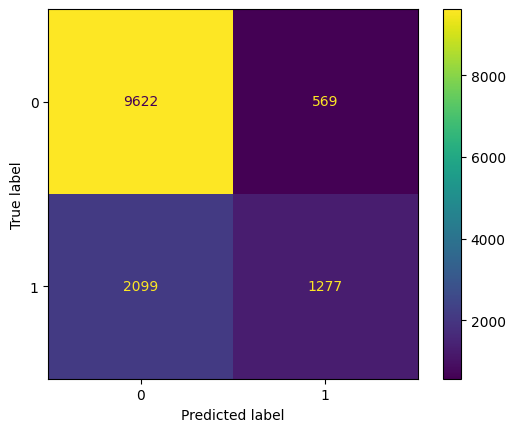

In [7]:
cm = confusion_matrix(test_labels,pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
cm_display.plot()
plt.show()

In [8]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, pred))

              precision    recall  f1-score   support

           0       0.82      0.94      0.88     10191
           1       0.69      0.38      0.49      3376

    accuracy                           0.80     13567
   macro avg       0.76      0.66      0.68     13567
weighted avg       0.79      0.80      0.78     13567



## Fairness Metrics Used
- average_odds_difference() : returns the average of the difference in FPR and TPR for the unprivileged and privileged groups. A value of 0 indicates equality of odds.

- equal_opportunity_difference() :Returns the difference in recall scores (TPR) between the unprivileged and
    privileged groups. A value of 0 indicates equality of opportunity.
    
- statistical_parity_difference() : measures the difference that the majority and protected classes receive a favorable outcome. This measure must be equal to 0 to be fair.

*Reference Link:* https://aif360.readthedocs.io/en/stable/modules/sklearn.html?highlight=metrics#module-aif360.sklearn.metrics

In [9]:
equal_opportunity_sex = equal_opportunity_difference(test_labels, pred, prot_attr='sex')
print(f'Fairness value for equal_opportunity_difference metric and protected attribute sex is: {equal_opportunity_sex}')
equal_opportunity_race = equal_opportunity_difference(test_labels, pred, prot_attr='race')
print(f'Fairness value for equal_opportunity_difference metric and protected attribute race is: {equal_opportunity_race}')

Fairness value for equal_opportunity_difference metric and protected attribute sex is: -0.1892707527579314
Fairness value for equal_opportunity_difference metric and protected attribute race is: 0.08506783377085875


In [10]:
statistical_parity_sex = statistical_parity_difference(test_labels, pred, prot_attr='sex')
print(f'Fairness value for statistical_parity_difference metric is and protected attribute sex is: {statistical_parity_sex} ')
statistical_parity_race = statistical_parity_difference(test_labels, pred, prot_attr='race')
print(f'Fairness value for statistical_parity_difference metric and protected attribute race is: {statistical_parity_race} ')

Fairness value for statistical_parity_difference metric is and protected attribute sex is: -0.1242549135687587 
Fairness value for statistical_parity_difference metric and protected attribute race is: -0.01306003345076688 


In [11]:
average_odds_sex = average_odds_difference(test_labels,pred,prot_attr='sex')
print(f'Fairness value for average_odds_difference metric and protected attribute sex is: {average_odds_sex} ')
average_odds_race = average_odds_difference(test_labels,pred,prot_attr='race')
print(f'Fairness value for average_odds_difference metric and protected attribute race is: {average_odds_race} ')

Fairness value for average_odds_difference metric and protected attribute sex is: -0.11488857216478567 
Fairness value for average_odds_difference metric and protected attribute race is: 0.04558337318497721 


### Get Explanation Function
`get_explanation()` function computes the FALE scores for all the features of the dataset based on the protective attribute and the fairness metric we select.

In [12]:
column_index = {f: i for i, f in enumerate(transformer.get_feature_names())}
feature_columns = transformer.get_feature_names()
feature = transformer.get_feature_names()
feature.remove('sex')
feature.remove('race')

def get_explanation(metric,prot_attr):
    explanations = OrderedDict()
    for feature_name in feature:
        i = column_index[feature_name]
        if i in categorical_features:
            features = categorical_order(data = test,feature_columns = feature_columns,categorical_features = categorical_features, column = i)
            scores = fale_categorical(data = test, features=features, column=i, feature_name=feature_name, feature_columns = feature_columns, categorical_names=categorical_names, predict_fn=model, test_labels=test_labels,prot_attr = prot_attr ,metric = metric)
        else:
            percentiles = np.linspace(0, 100, 10)
            bins = sorted(set(np.percentile(test[:, i], percentiles)))
            scores = fale_continuous(data=test, column=i, bins=bins,features_columns = feature_columns, predict_fn=model ,test_labels=test_labels,prot_attr = prot_attr ,metric = metric)      
        #sampled_scores = []

        #scores = scores.sort_index()
        explanations[feature_name] = \
                {"values": list(scores.index.values), "scores": scores.values}
    
    return explanations

### Get Fale Plots
`FALE_plots()` function draws the FALE plots for each feature.

### Fale Plots for fairness metric `average_odds_difference`

In [13]:
data = transformer.invert(test).to_pd()
data['sex'] = np.where((data['sex'] == 1.0) , 'Male','Female')
data['race'] = np.where((data['race'] == 1.0) , 'White','Non-White')

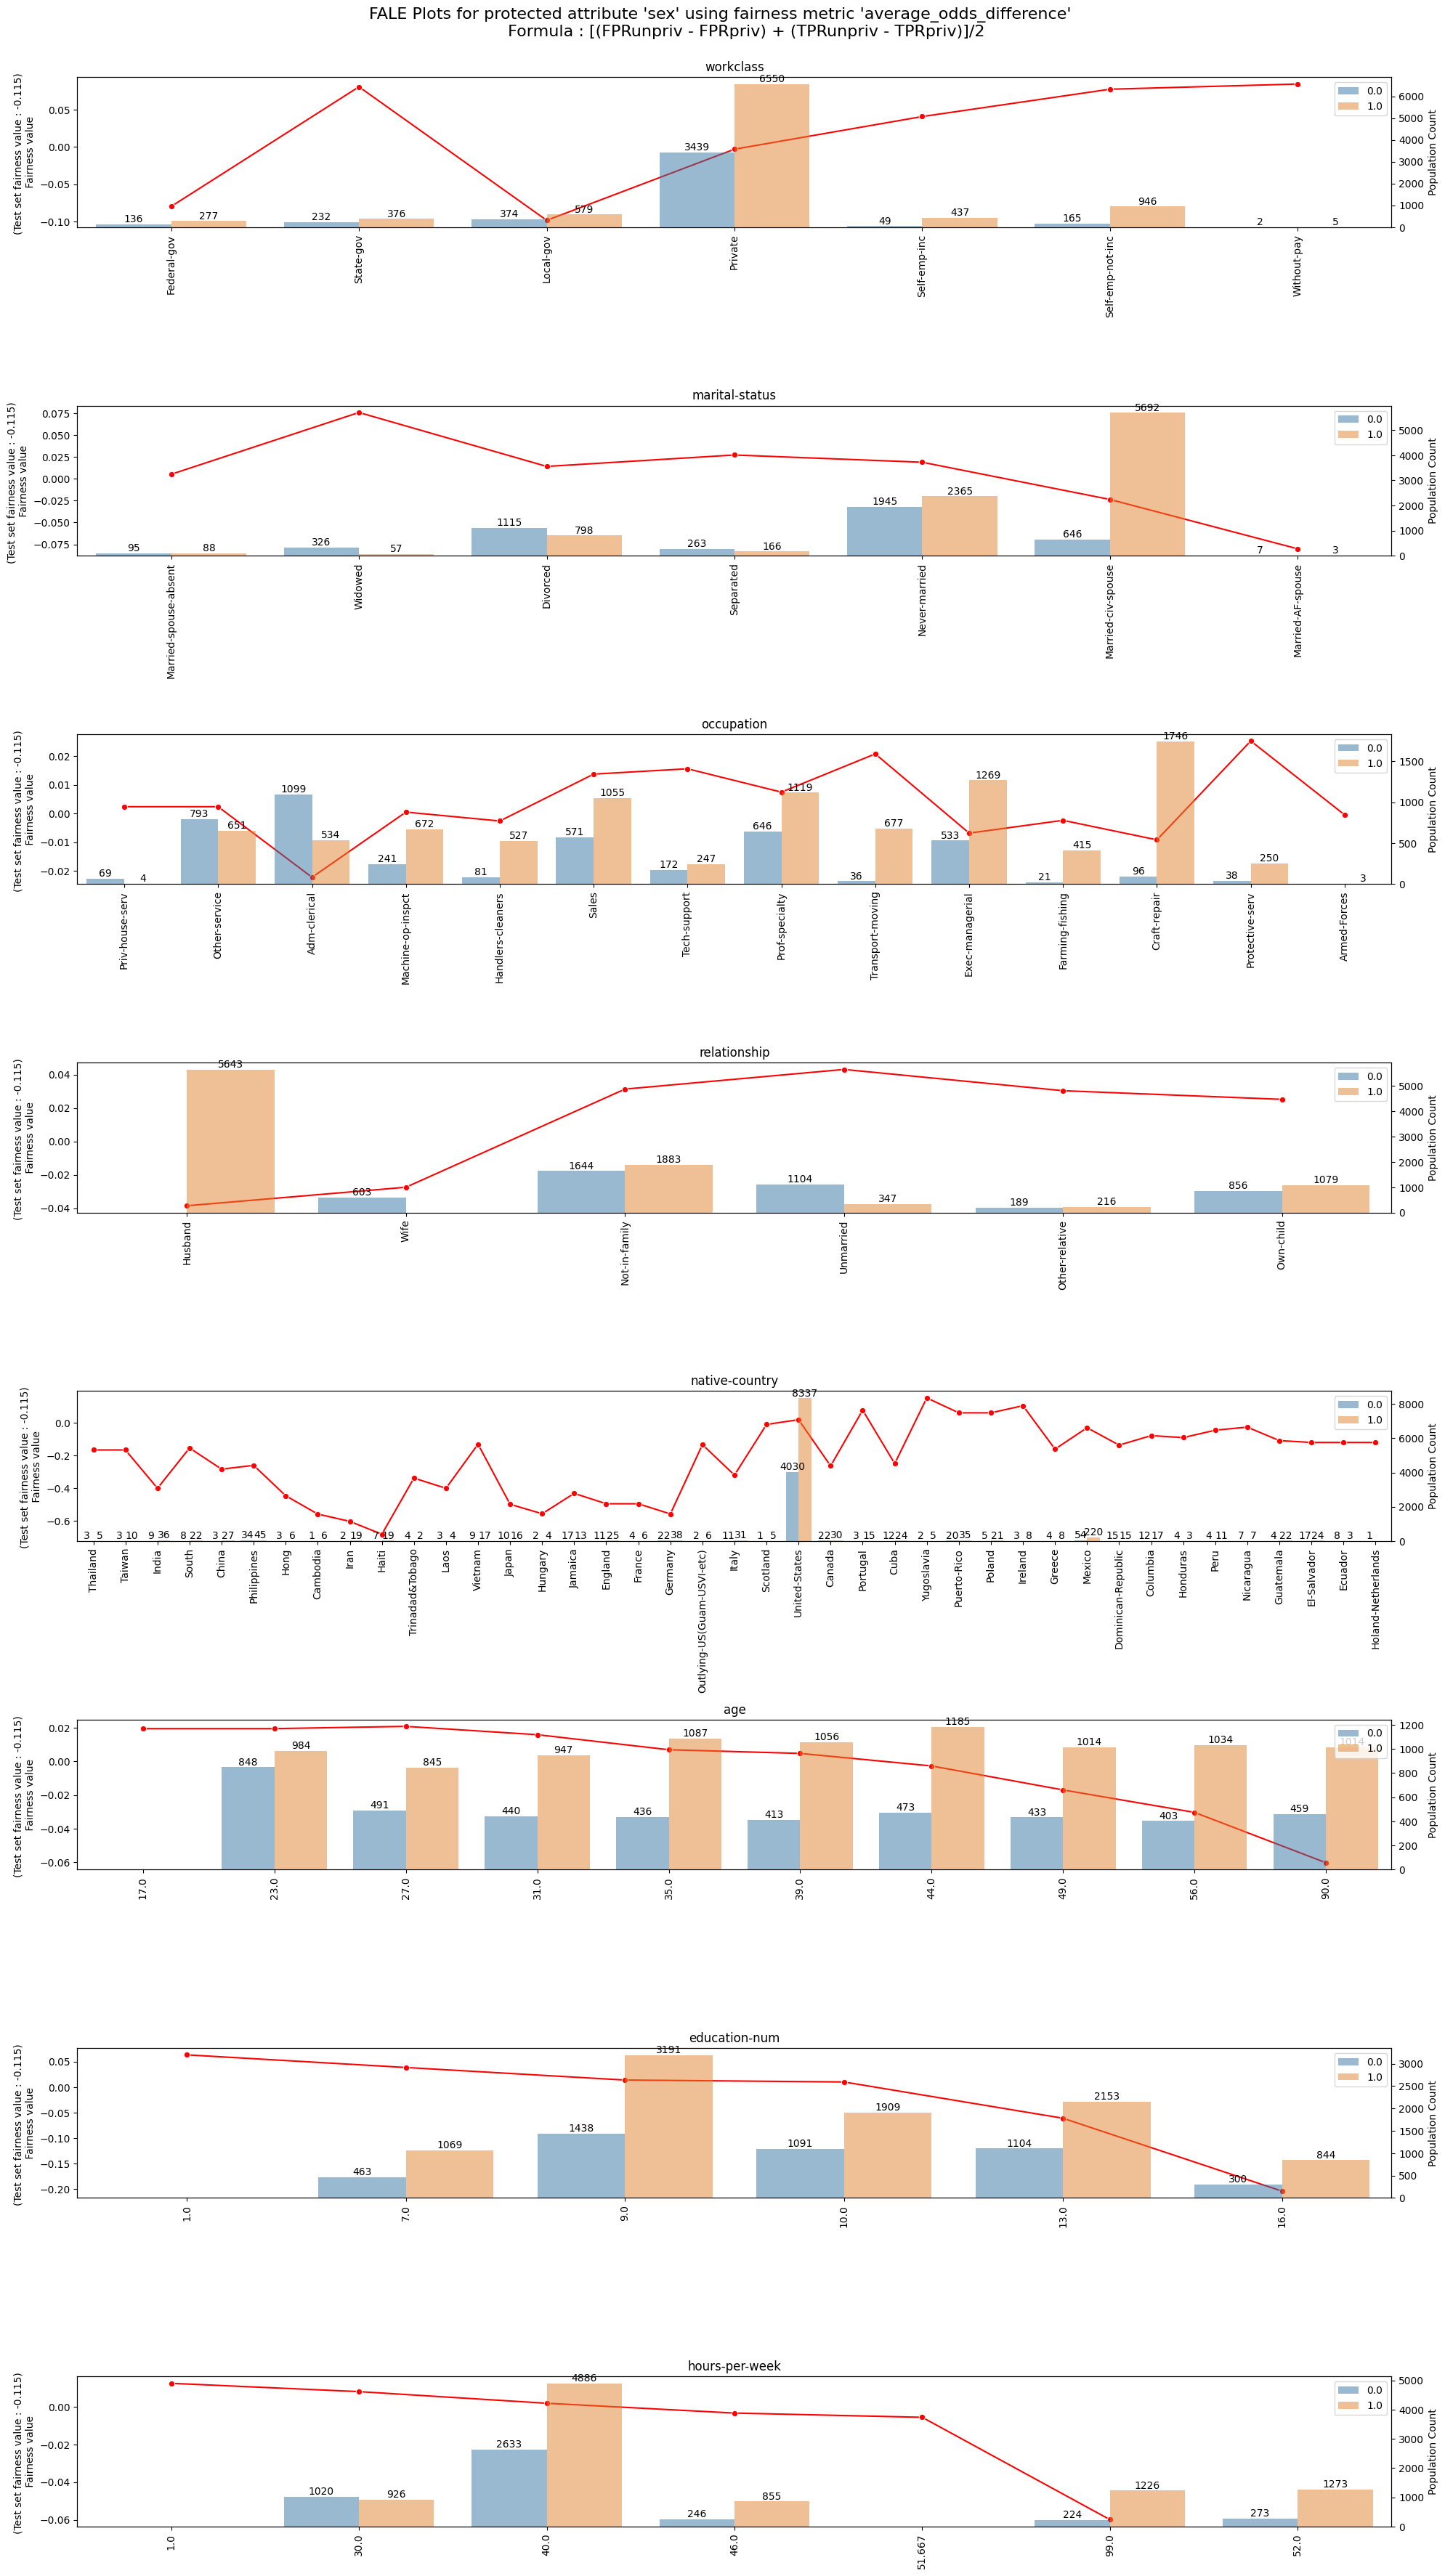

Population size : 13567
sex
Male      9170
Female    4397
Name: count, dtype: int64
Time elapsed : 5 seconds


In [14]:
import time
tic = time.time() 

explanations = get_explanation(metric = average_odds_difference,prot_attr='sex')
FALE_plots(explanations = explanations,metric = average_odds_difference,prot_attr='sex',data=transformer.invert(test).to_pd(),feature=feature,categorical_columns=categorical_columns,test_labels=test_labels,pred=pred)
print(f'Population size : {len(test)}')
print(data['sex'].value_counts())
toc = time.time()
time = toc - tic
print(f'Time elapsed : {round(time)} seconds')

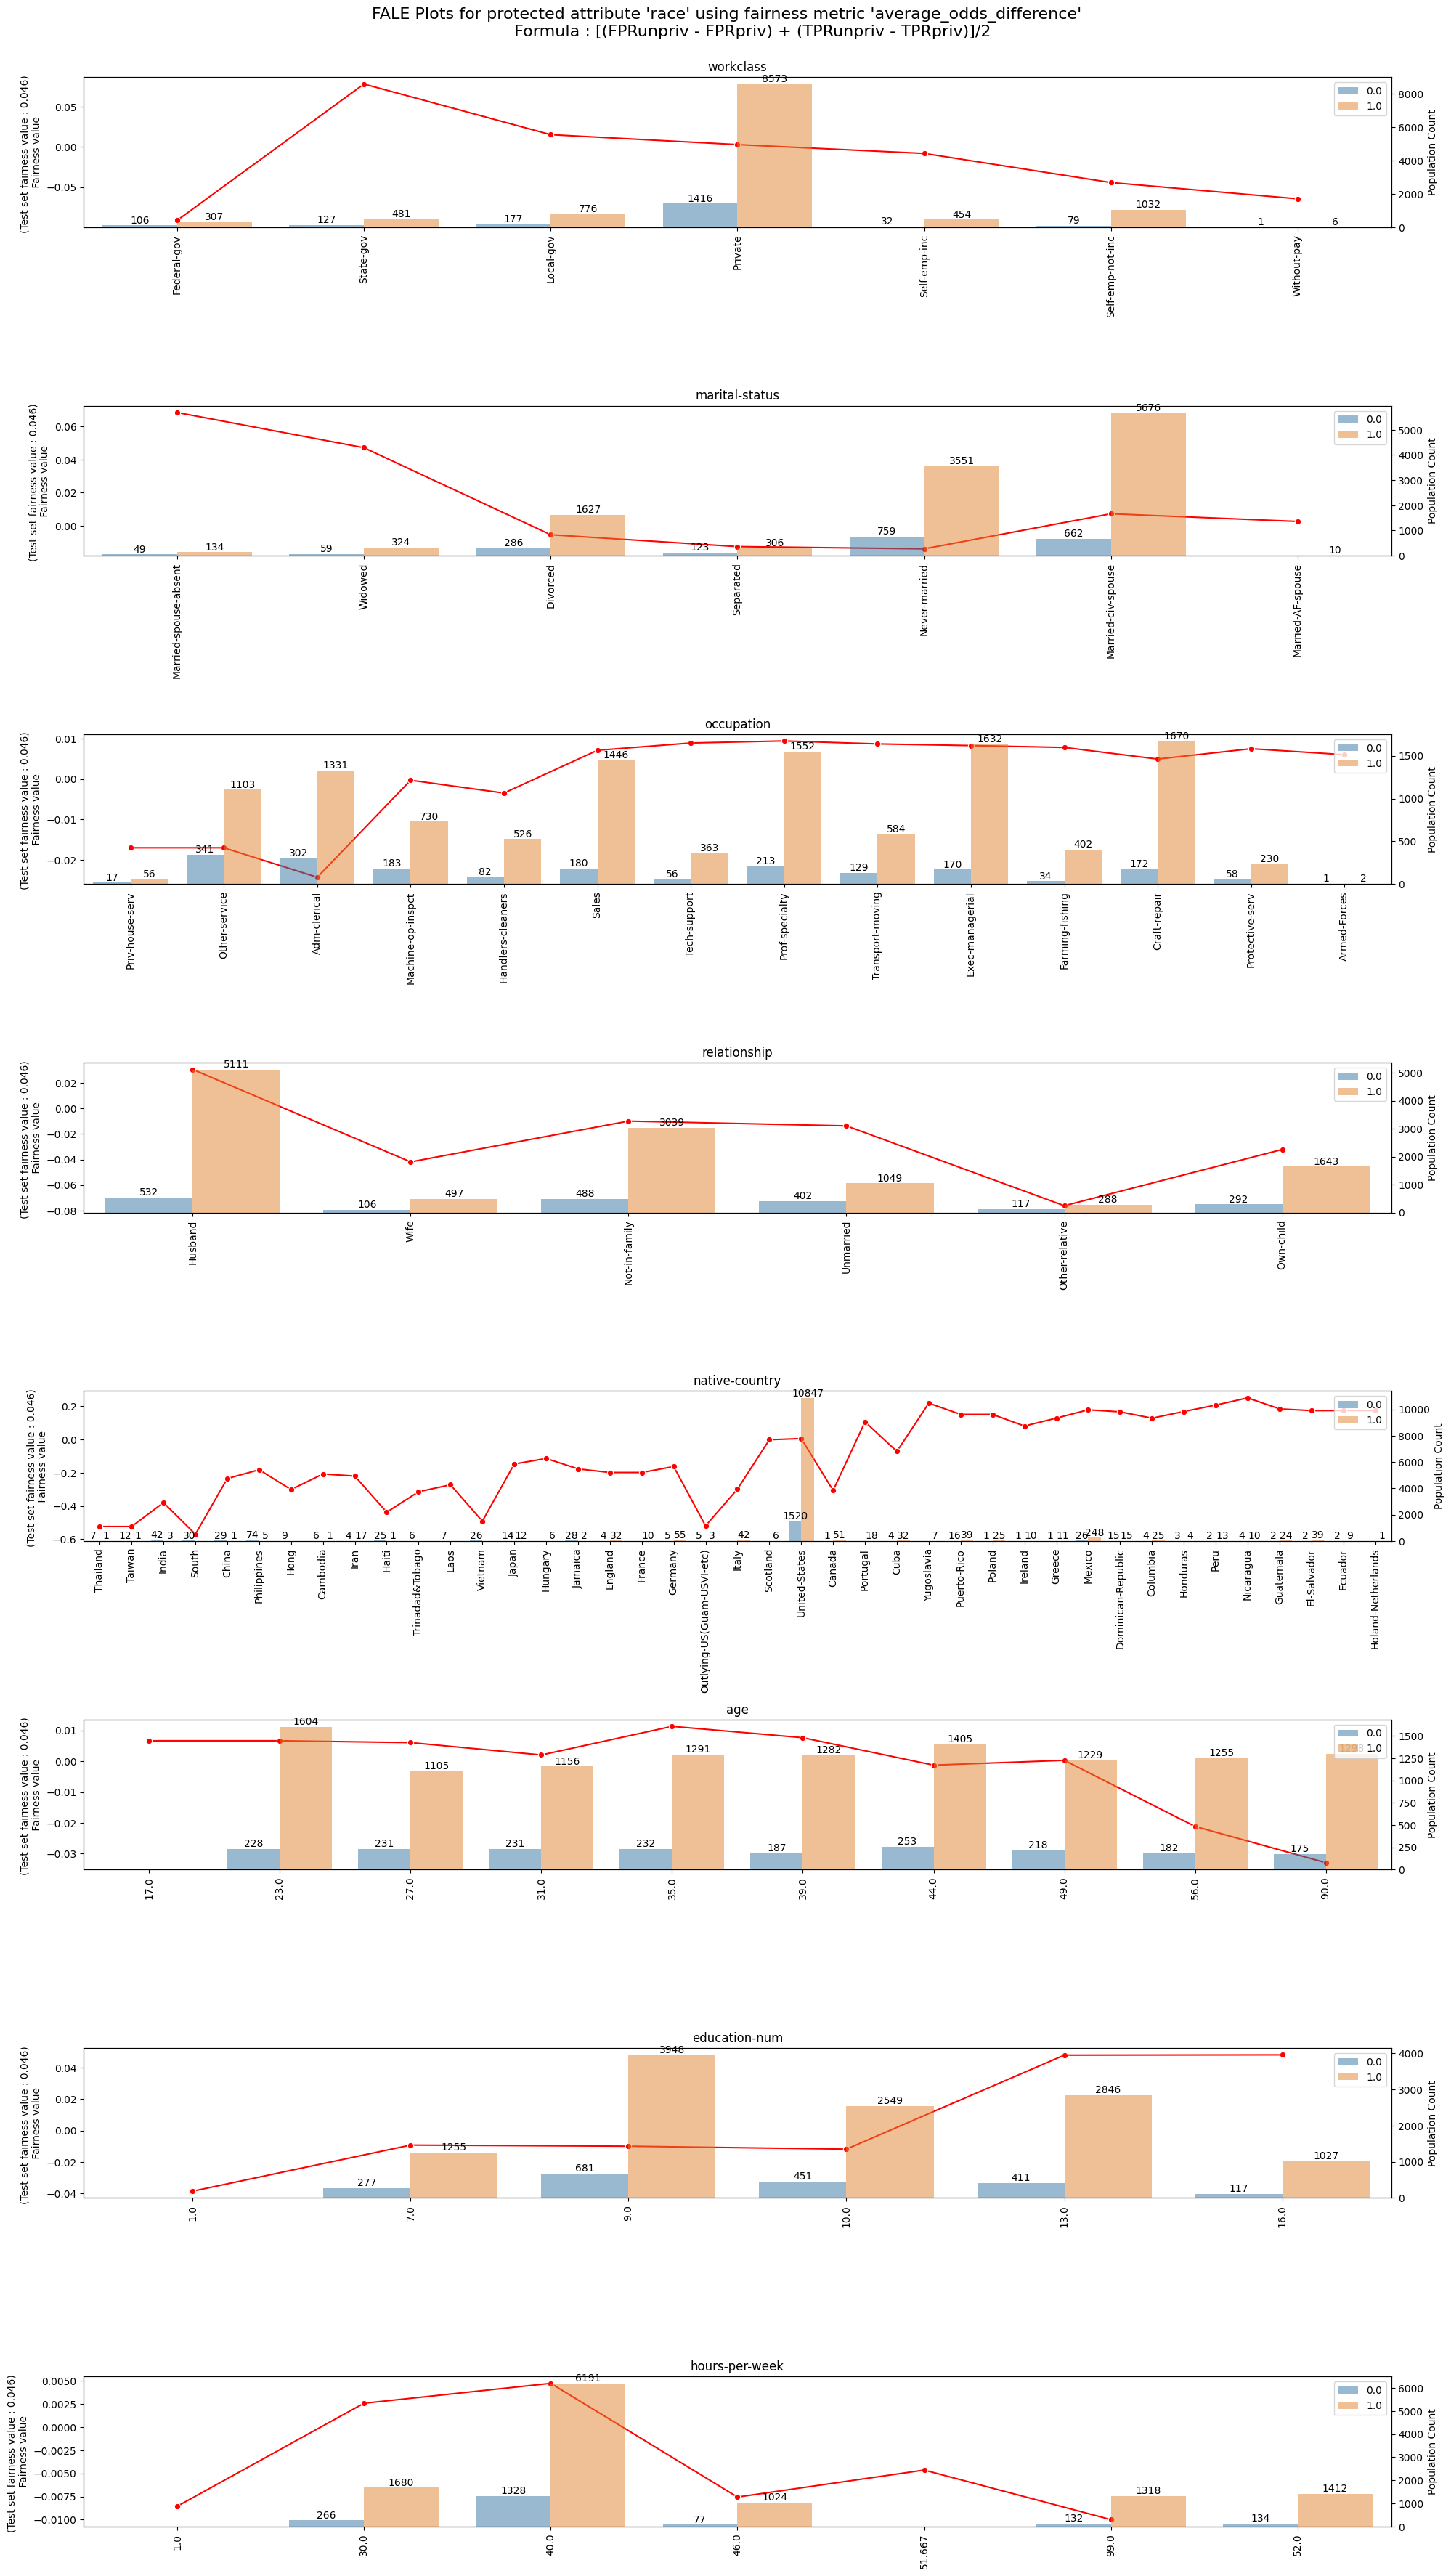

Population size : 13567
race
White        11629
Non-White     1938
Name: count, dtype: int64
Time elapsed : 5 seconds


In [15]:
import time
tic1 = time.time() 
explanations = get_explanation(metric = average_odds_difference,prot_attr='race')
FALE_plots(explanations = explanations,metric = average_odds_difference,prot_attr='race',data=transformer.invert(test).to_pd(),feature=feature,categorical_columns=categorical_columns,test_labels=test_labels,pred=pred)
print(f'Population size : {len(test)}')
print(data['race'].value_counts())
toc1 = time.time()
time = toc1 - tic1
print(f'Time elapsed : {round(time)} seconds')

### Fale Plots for fairness metric `equal_opportunity_difference`

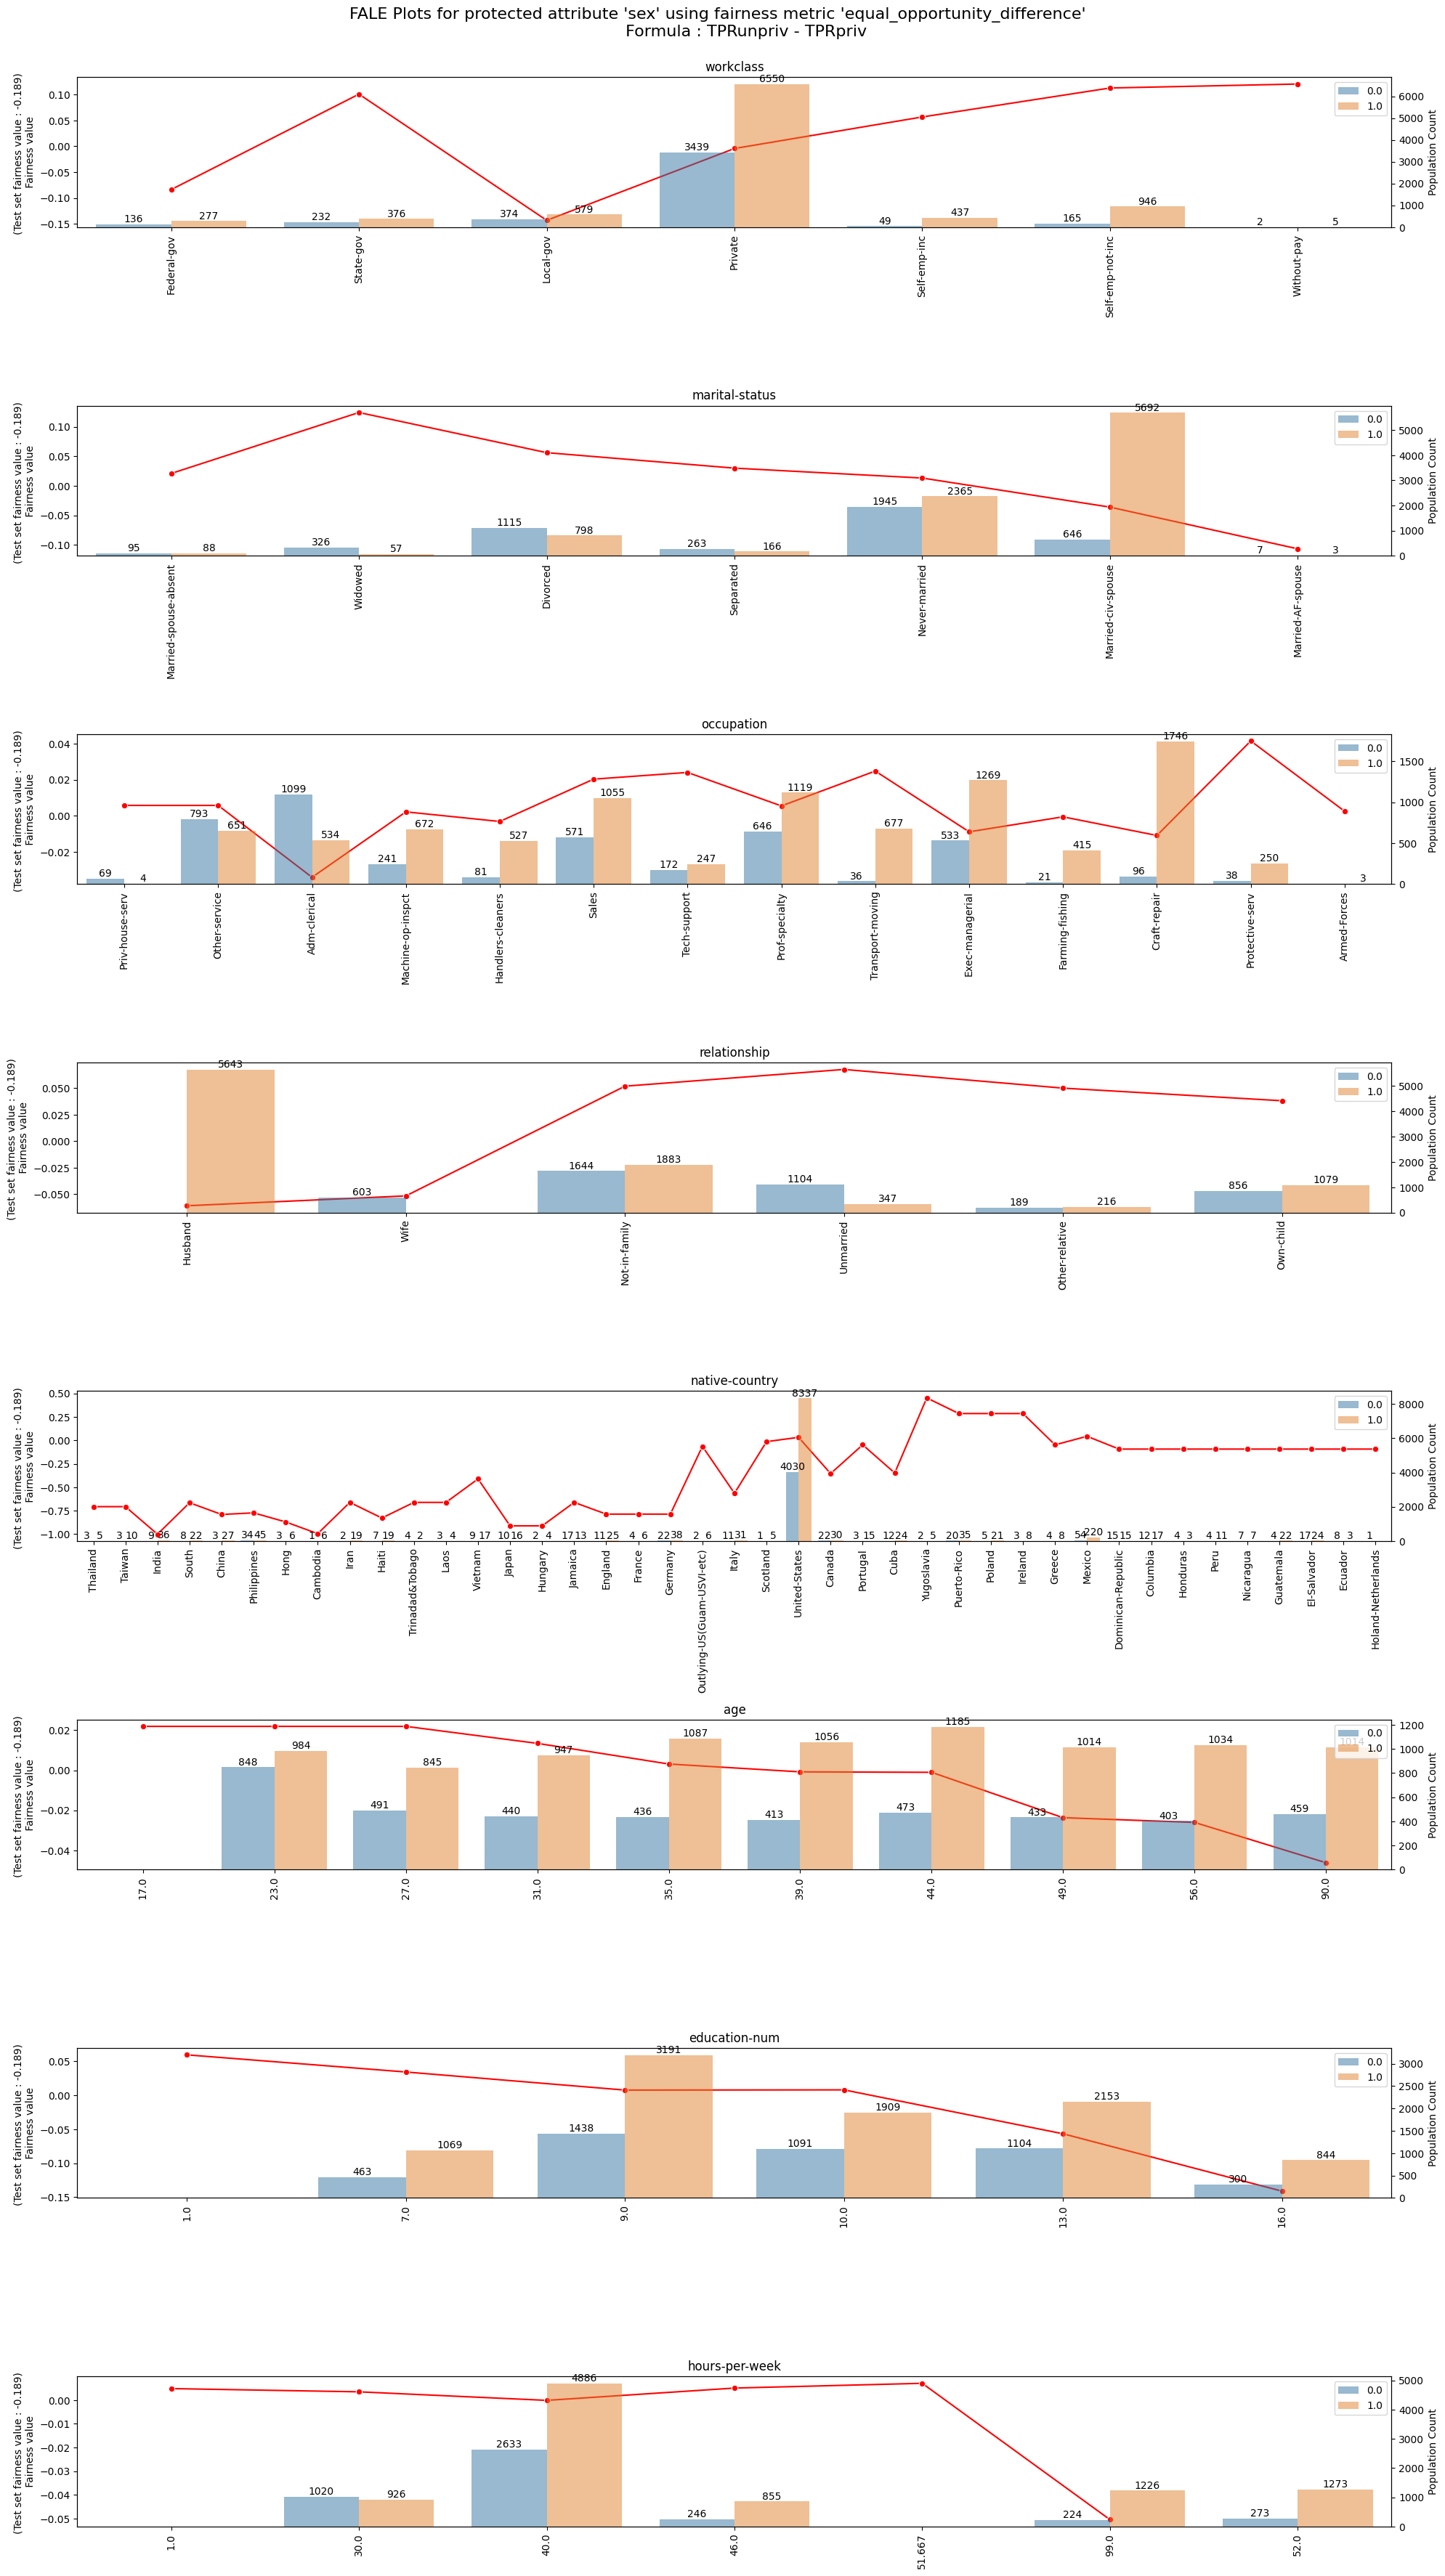

Population size : 13567
sex
Male      9170
Female    4397
Name: count, dtype: int64
Time elapsed : 5 seconds


In [16]:
import time
tic2 = time.time()
explanations = get_explanation(metric = equal_opportunity_difference,prot_attr='sex')
FALE_plots(explanations = explanations,metric = equal_opportunity_difference,prot_attr='sex',data=transformer.invert(test).to_pd(),feature=feature,categorical_columns=categorical_columns,test_labels=test_labels,pred=pred)
print(f'Population size : {len(test)}')
print(data['sex'].value_counts())
toc2 = time.time()
time = toc2 - tic2
print(f'Time elapsed : {round(time)} seconds')

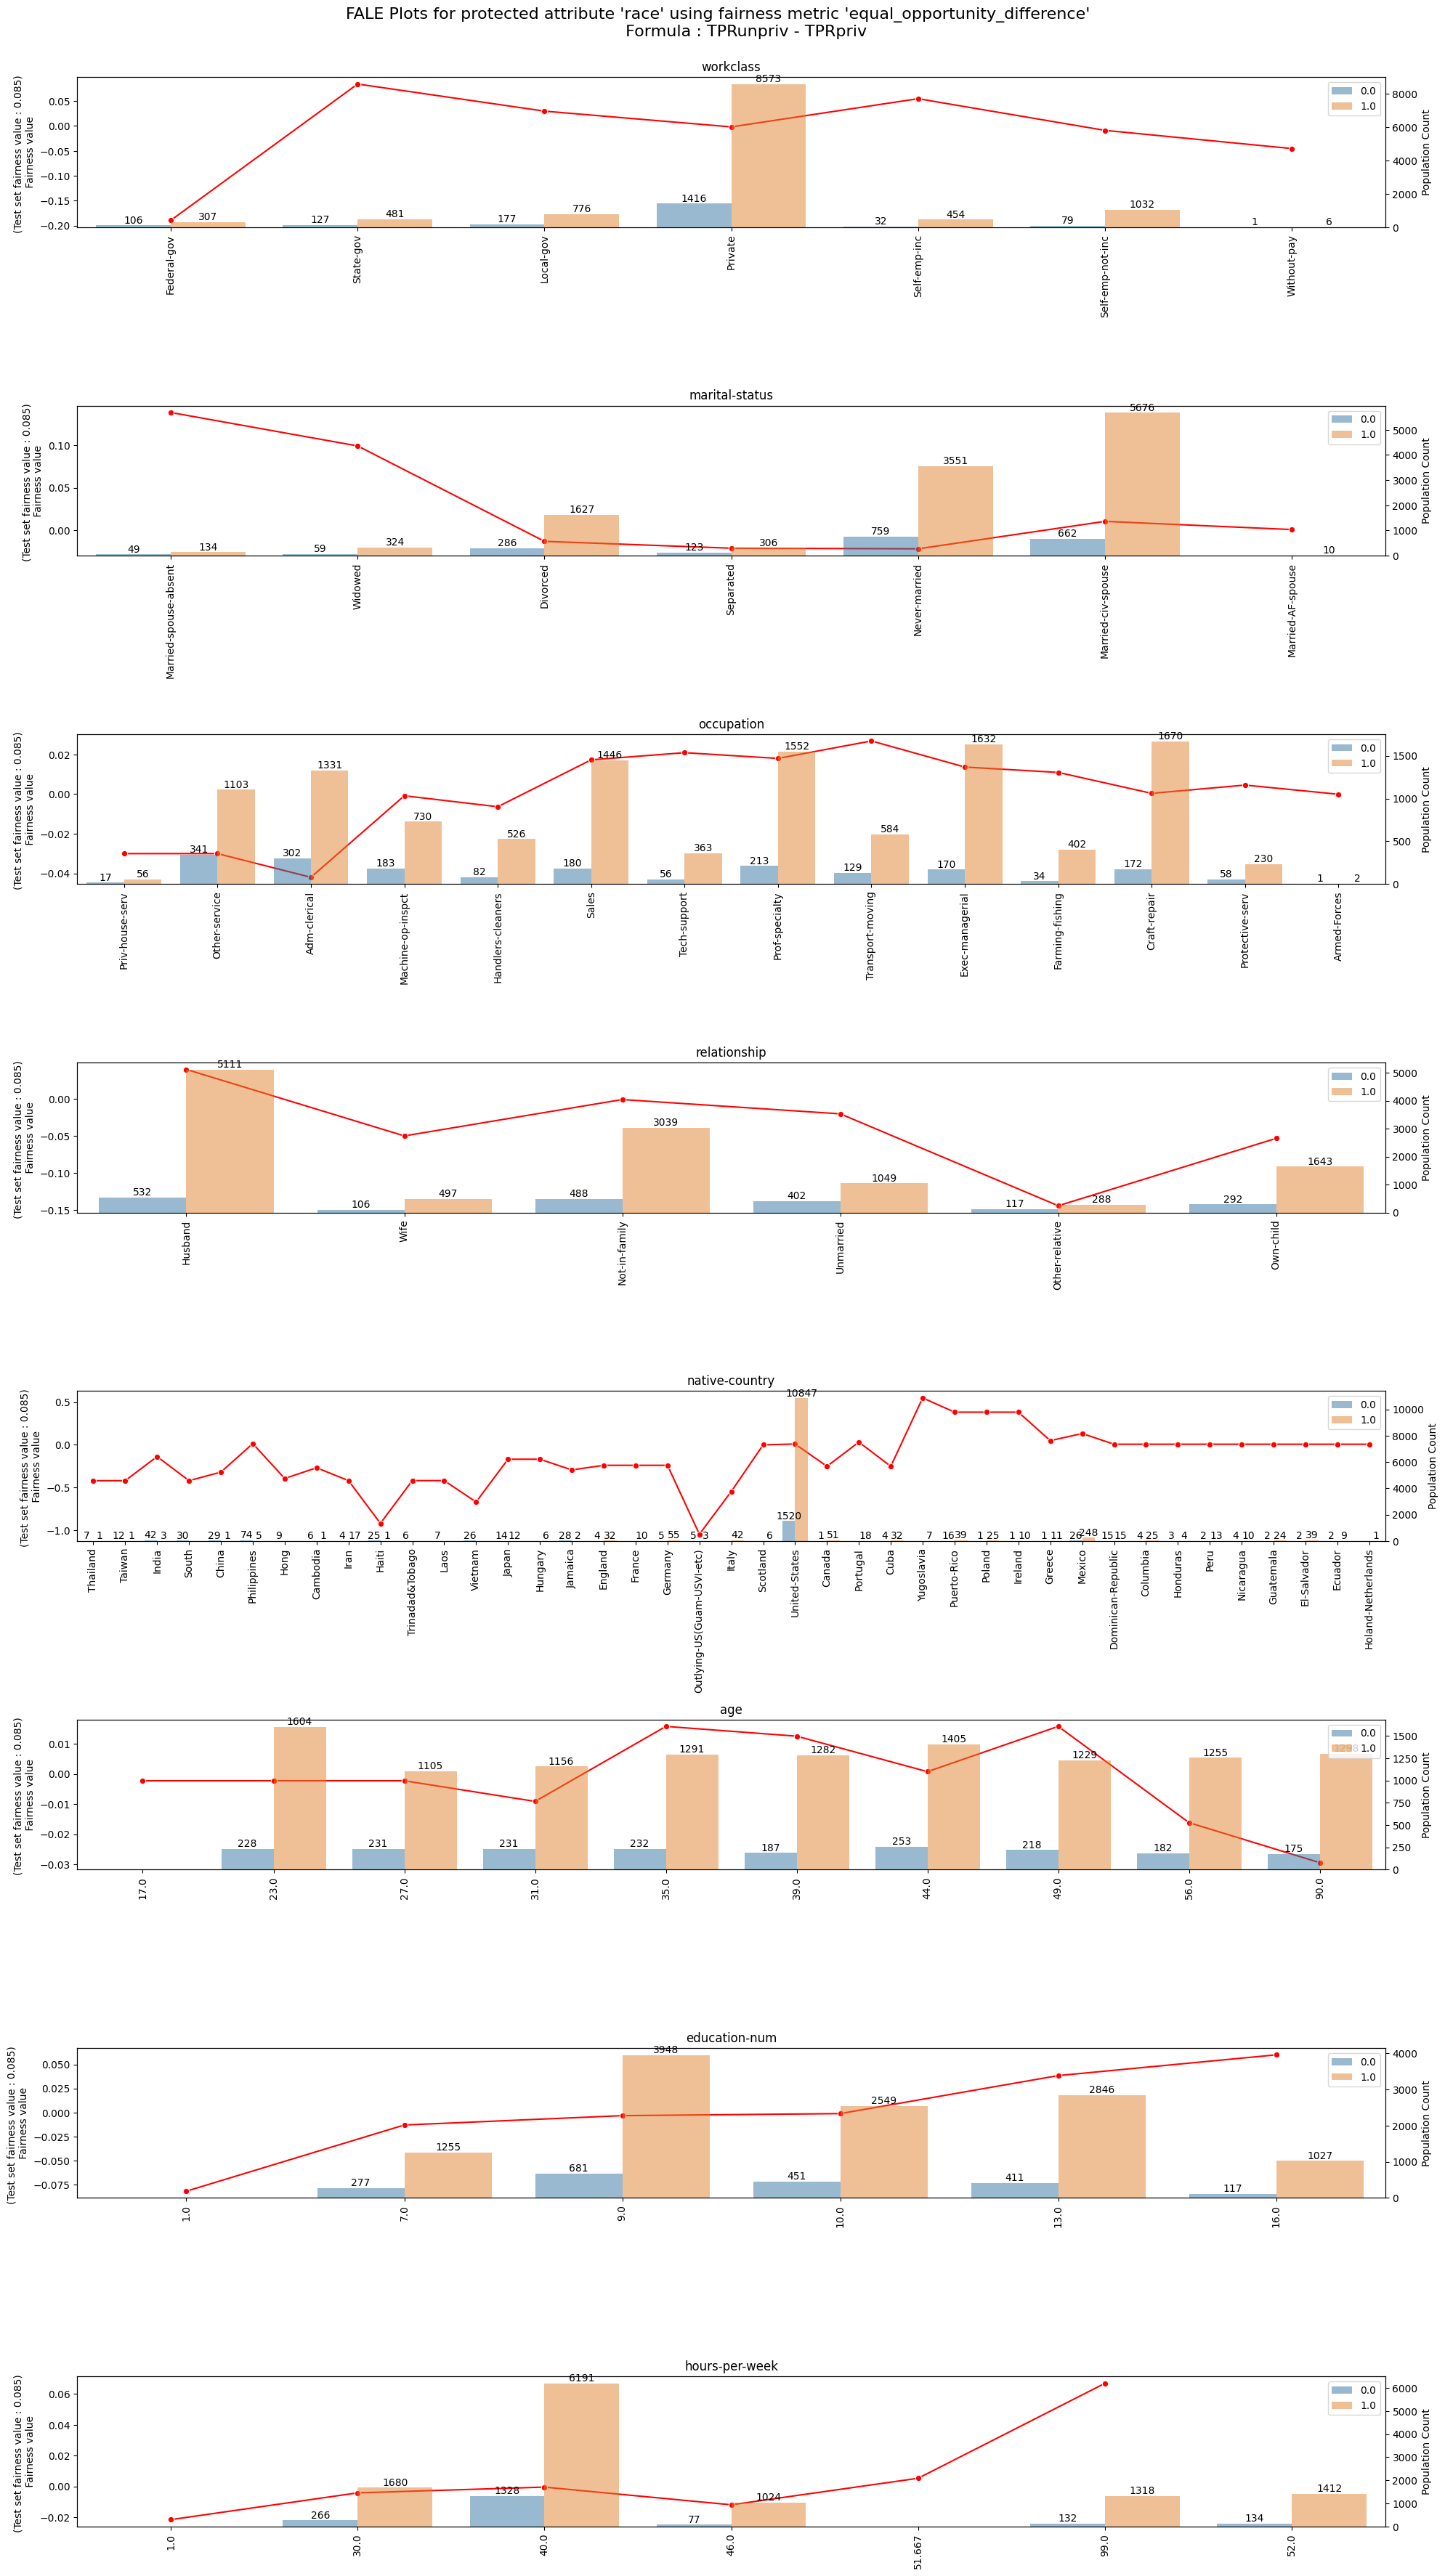

Population size : 13567
race
White        11629
Non-White     1938
Name: count, dtype: int64
Time elapsed : 5 seconds


In [17]:
import time

tic3 = time.time()
explanations = get_explanation(metric = equal_opportunity_difference,prot_attr='race')
FALE_plots(explanations = explanations,metric = equal_opportunity_difference,prot_attr='race',data=transformer.invert(test).to_pd(),feature=feature,categorical_columns=categorical_columns,test_labels=test_labels,pred=pred)
print(f'Population size : {len(test)}')
print(data['race'].value_counts())
toc3 = time.time()
time = toc3 - tic3
print(f'Time elapsed : {round(time)} seconds')

### Fale Plots for fairness metric `statistical_parity_difference`

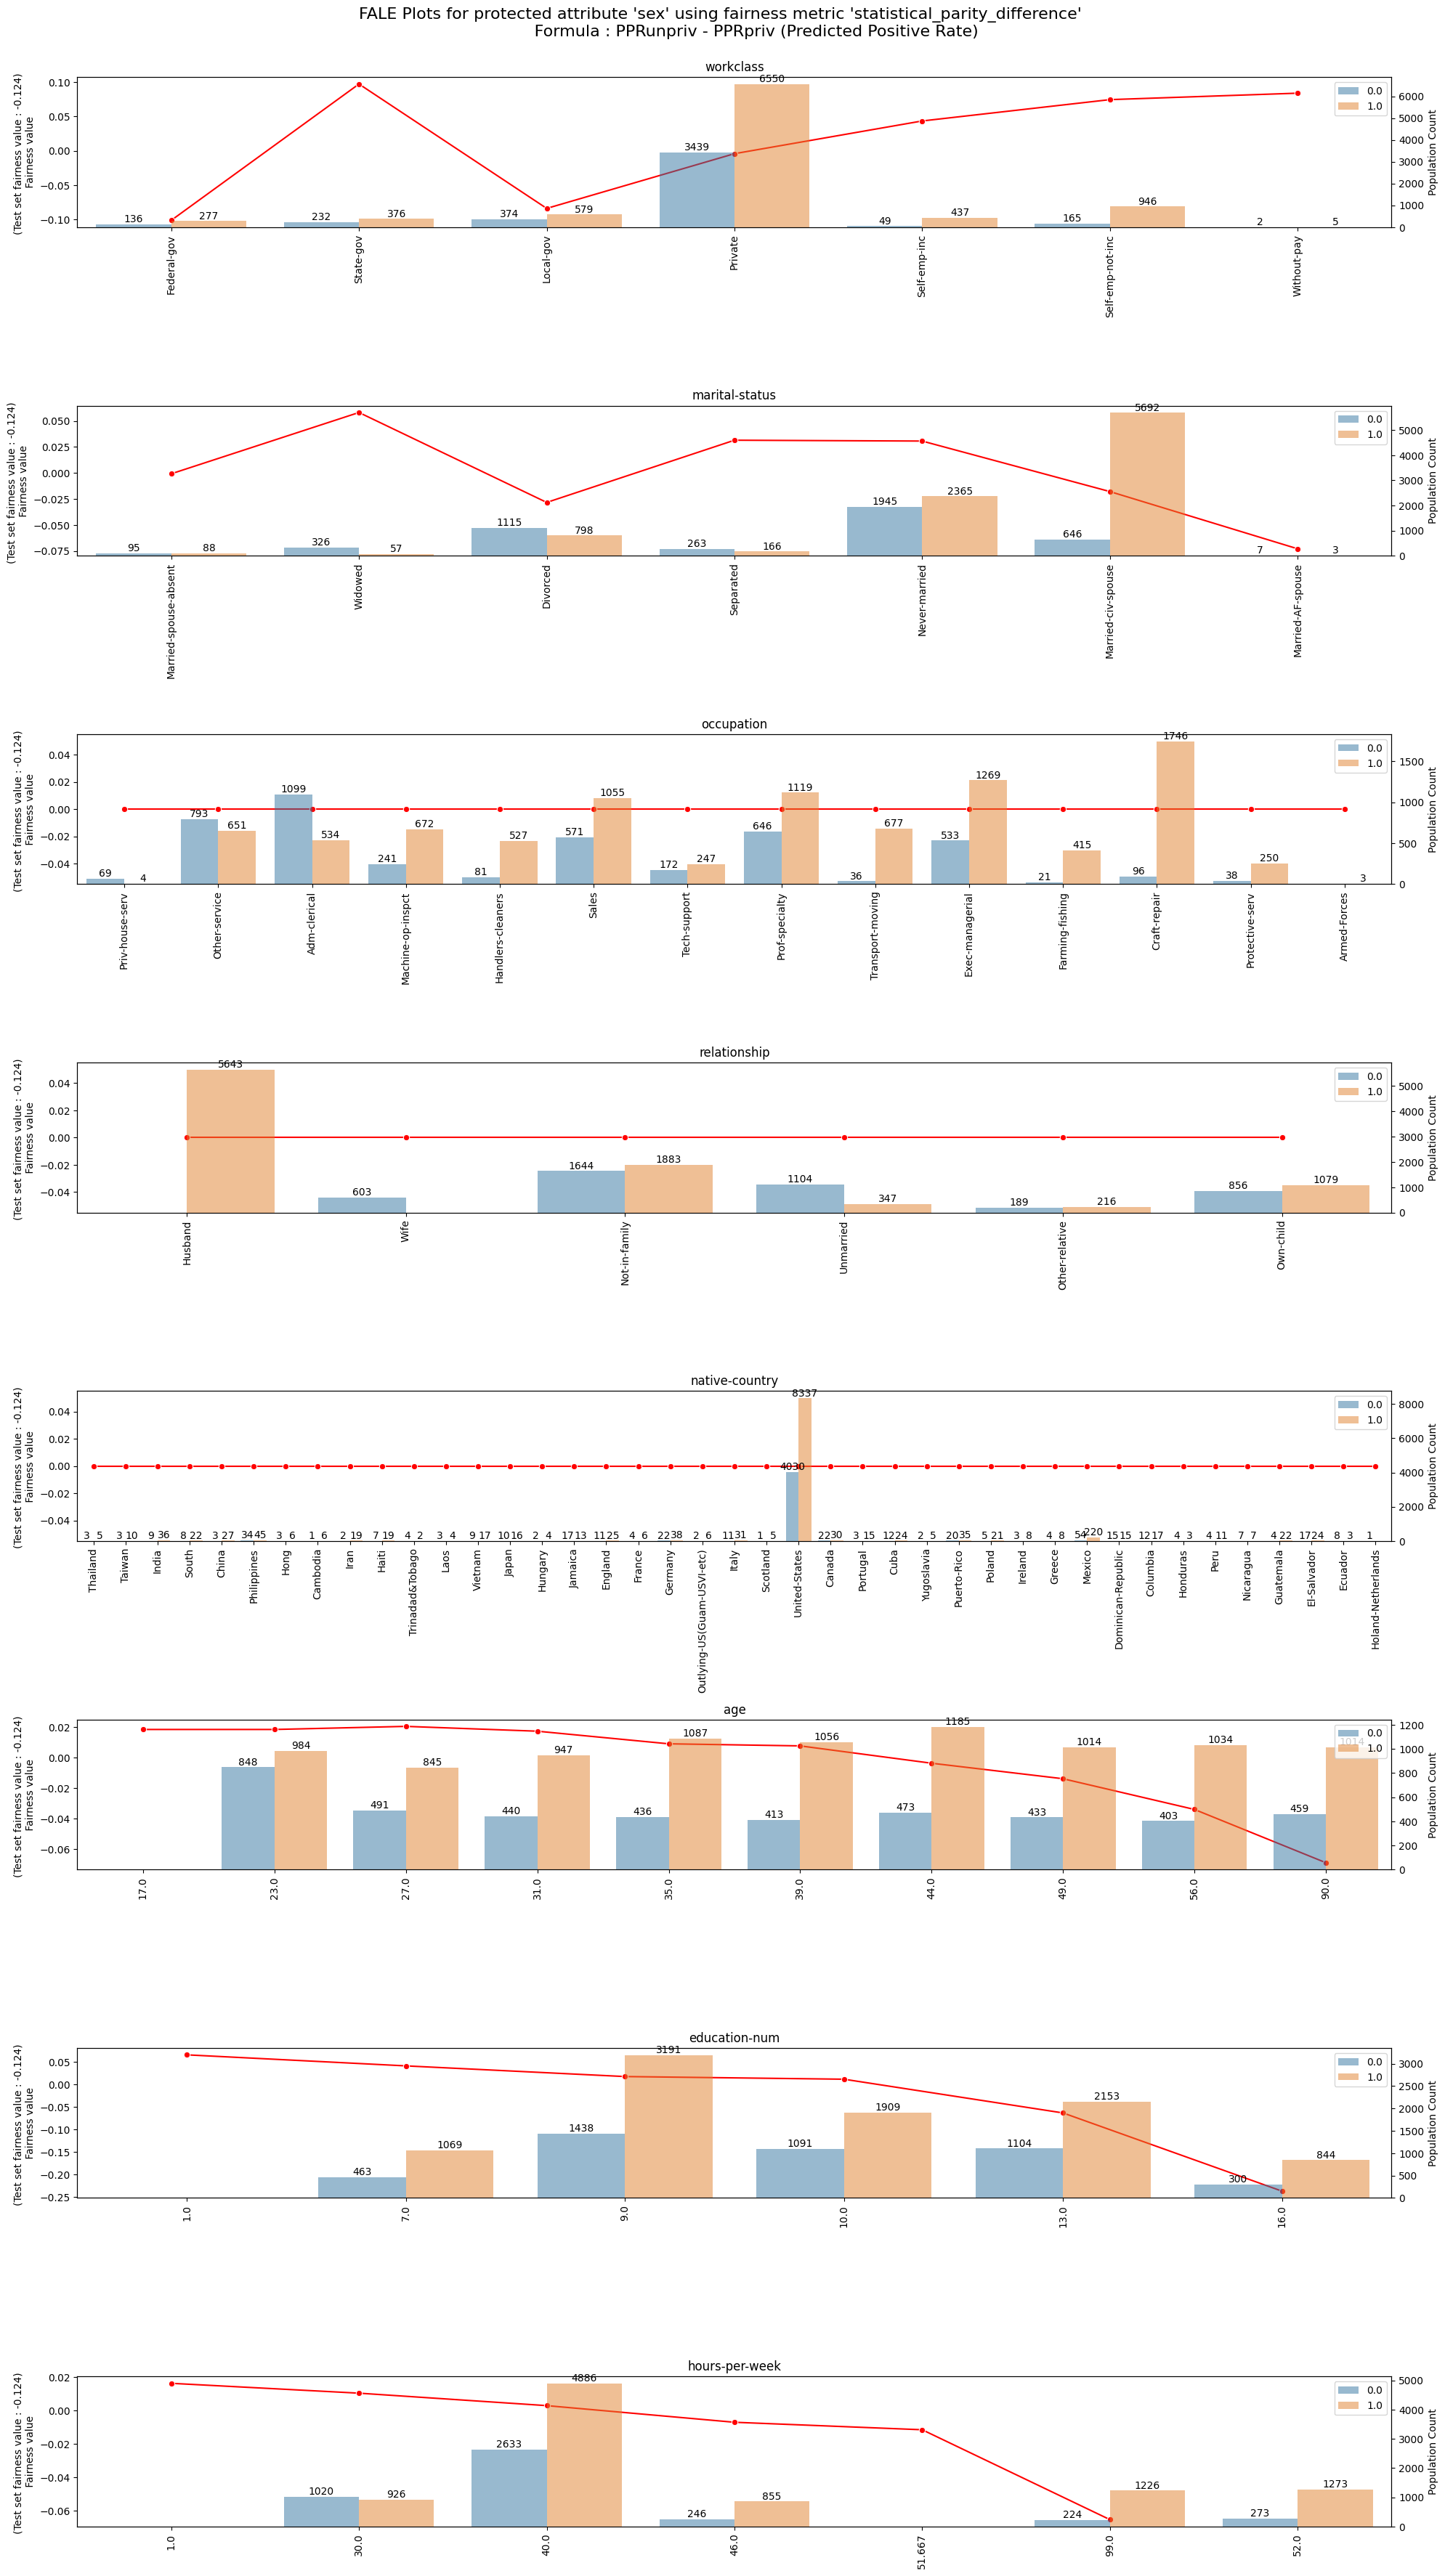

Population size : 13567
sex
Male      9170
Female    4397
Name: count, dtype: int64
Time elapsed : 5 seconds


In [18]:
import time

tic4 = time.time()
explanations = get_explanation(metric = statistical_parity_difference,prot_attr='sex')
FALE_plots(explanations = explanations,metric = statistical_parity_difference,prot_attr='sex',data=transformer.invert(test).to_pd(),feature=feature,categorical_columns=categorical_columns,test_labels=test_labels,pred=pred)
print(f'Population size : {len(test)}')
print(data['sex'].value_counts())
toc4 = time.time()
time = toc4 - tic4
print(f'Time elapsed : {round(time)} seconds')

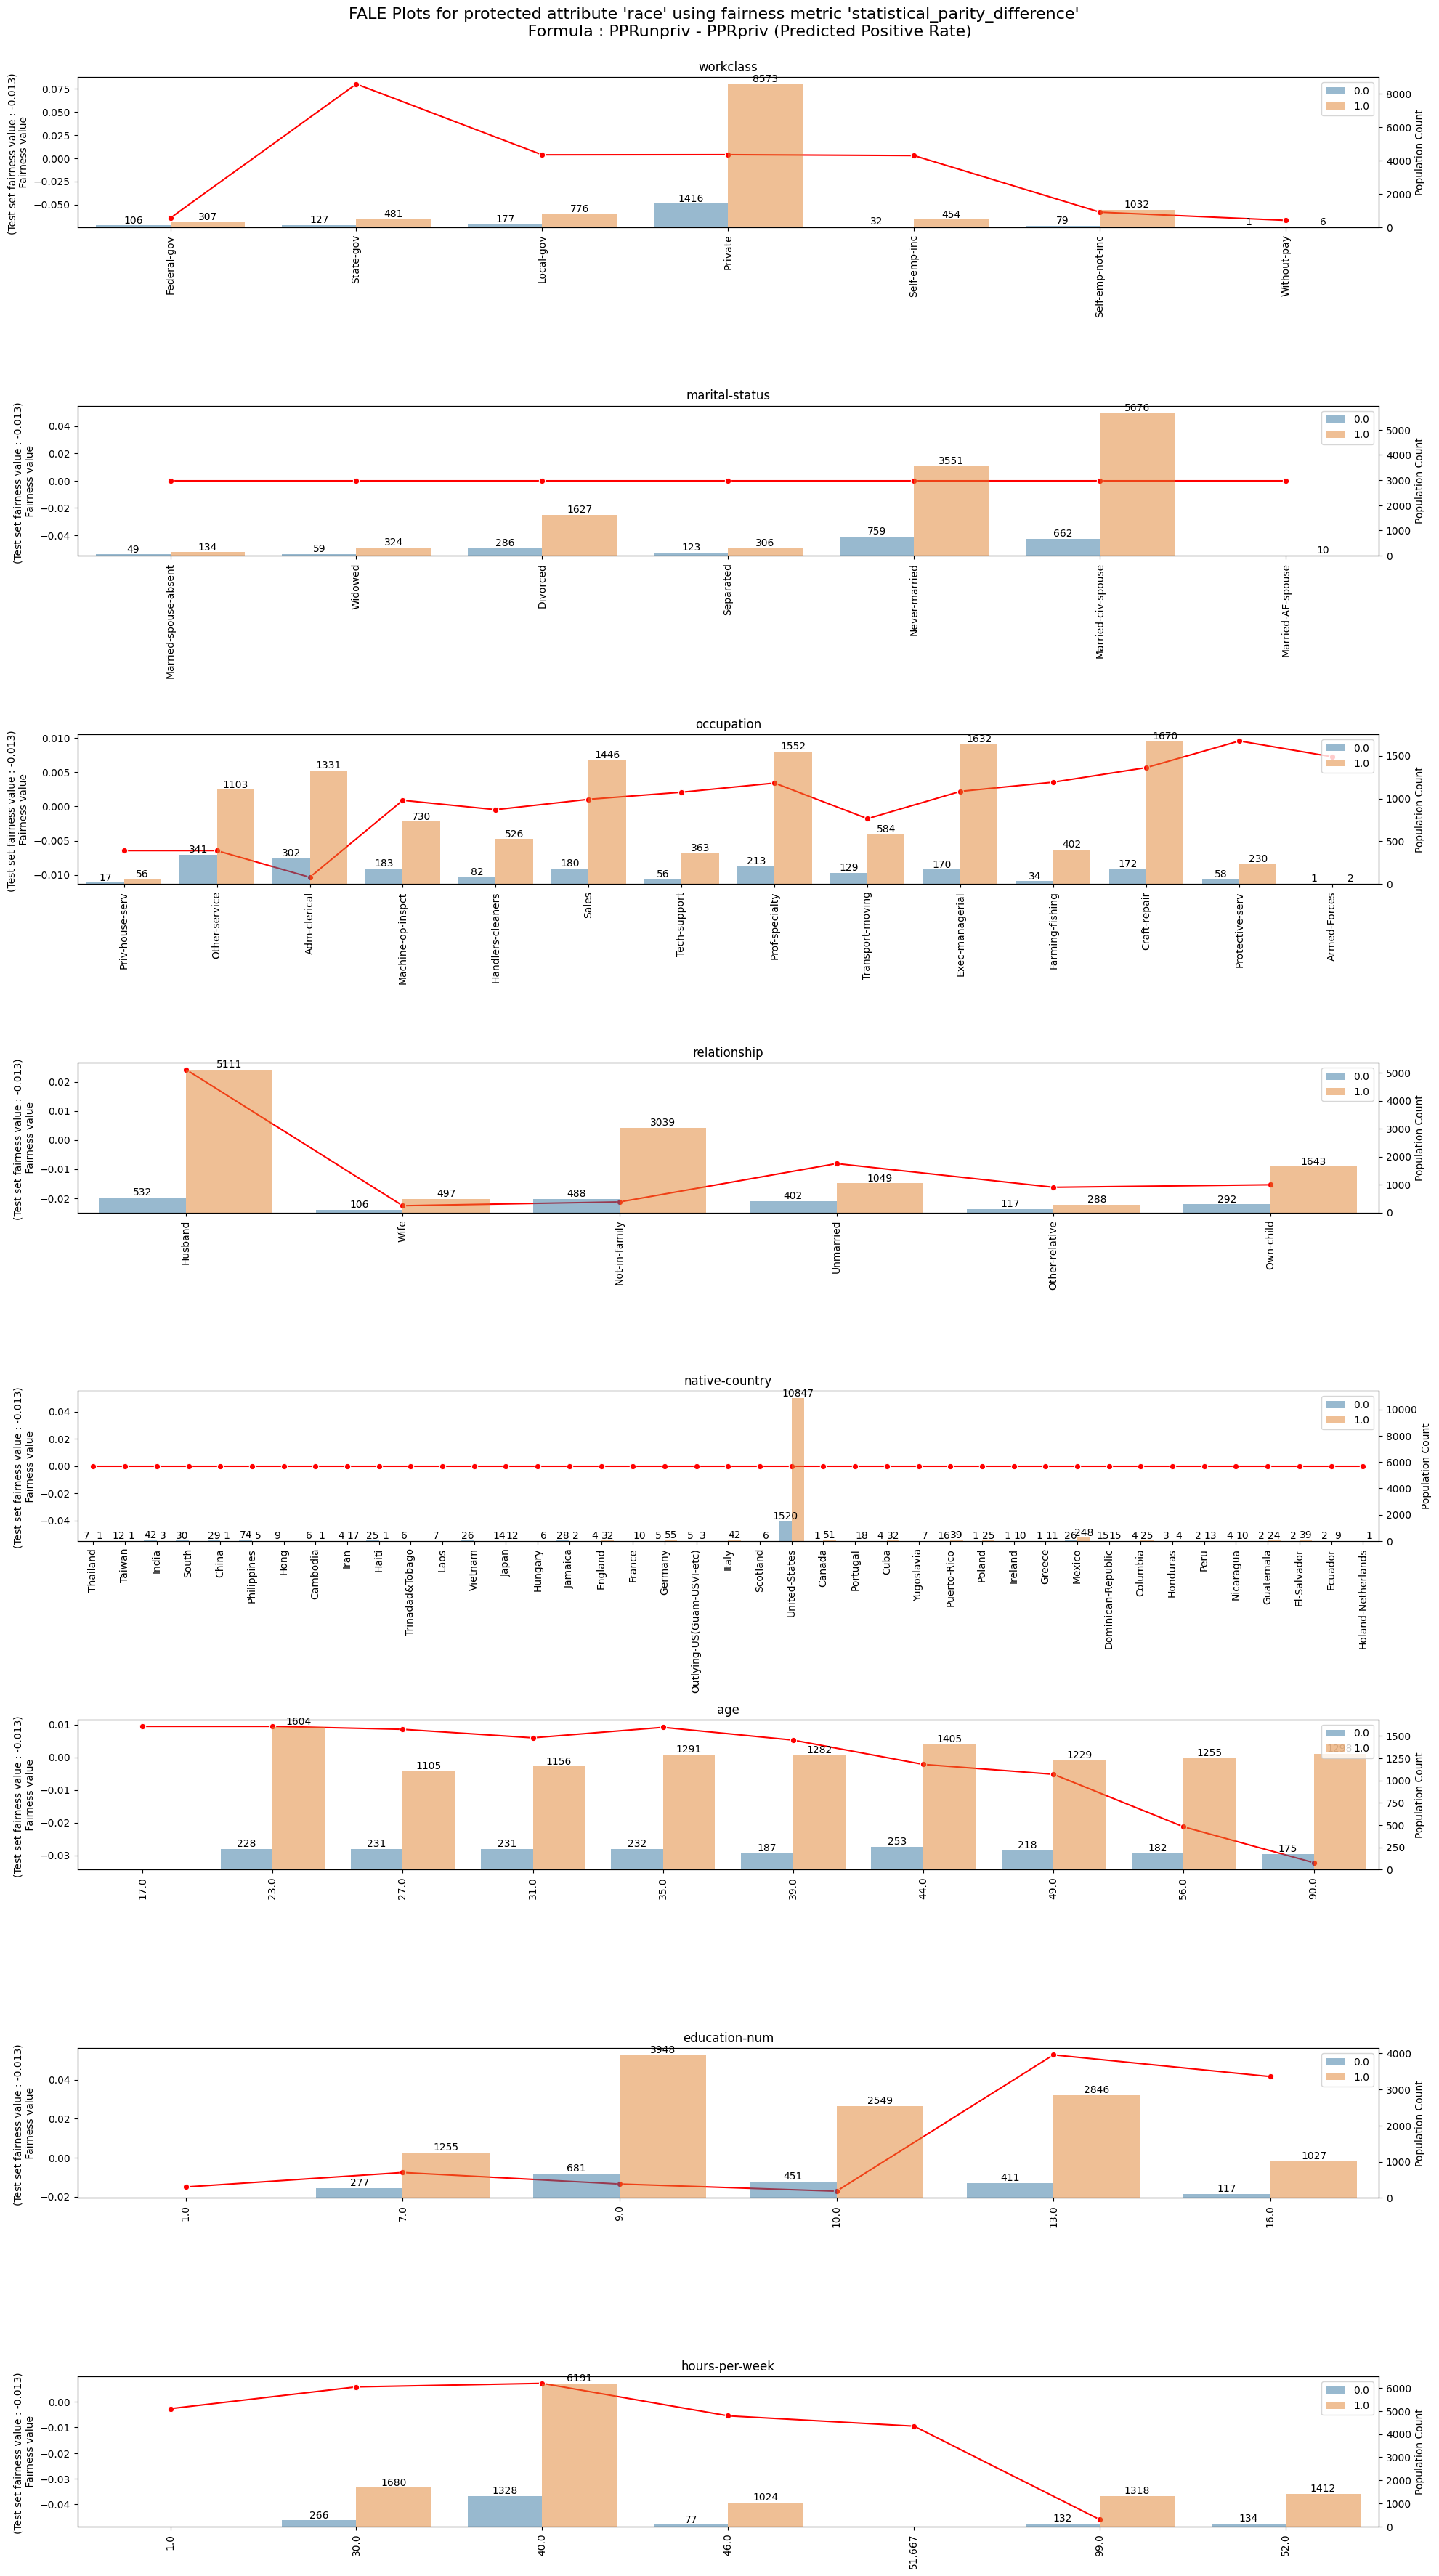

Population size : 13567
race
White        11629
Non-White     1938
Name: count, dtype: int64
Time elapsed : 5 seconds


In [19]:
import time

tic5 = time.time()
explanations = get_explanation(metric = statistical_parity_difference,prot_attr='race')
FALE_plots(explanations = explanations,metric = statistical_parity_difference,prot_attr='race',data=transformer.invert(test).to_pd(),feature=feature,categorical_columns=categorical_columns,test_labels=test_labels,pred=pred)
print(f'Population size : {len(test)}')
print(data['race'].value_counts())
toc5 = time.time()
time = toc5 - tic5
print(f'Time elapsed : {round(time)} seconds')